Include all imports below.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer.primitives import Sampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import math

Calculate the binary representation of an integer.

In [2]:
# Translate an integer number into its binary representation.
def toBinary(val):
    binary = '' # declare an empty string
    loop = val

    while loop > 0:
        temp = loop % 2 # calculate the bit value
        loop = loop // 2
        binary += str(temp) # add the bit value to the bit string

    binary = binary[::-1]
    return binary

# Translate a binary number into its integer representation.
def toInteger(val: str):

    num = 0
    val = val[::-1] # take the reverse of the string of integers
    for i in range(len(val)):
        if val[i] == '0':
            continue
        else:
            num += 2**i

    return num

The $U_{f(a, N)}$ gate is implementet using the logic of $a^{power}  mod  N$ 

In [3]:
def c_amodN(a, power, N):
    to_binary = toBinary(N) # Generate the binary representation of the test number "N"
    n = len(to_binary)      # From the binary representation, we can determine the number of bits needed to build the circuit

    circuit = QuantumCircuit(n) # Create a new circuit
    
    for i in range(power):
        for j in range(n-1, 0, -1):
            circuit.swap(j-1, j)     # Swap all the gates linearly
        for j in range(n):
            circuit.x(j)             # Apply an x gate to all the qubits
    
    circuit.name = f'{a}^{power} mod {N}' # Rename the circuit based on the test value and the current power
    # display(circuit.draw('mpl'))
    circuit = circuit.to_gate()
    c_circuit = circuit.control()
    return c_circuit

Define the values for the test value "N" and the base value of "a".

In [4]:
N = 247
a = 5       # Define the value of "a" that will be used to implement the Shor's algorithm

print("Value of N =",N)

Value of N = 247


Build Shor's Quantum Circuit.

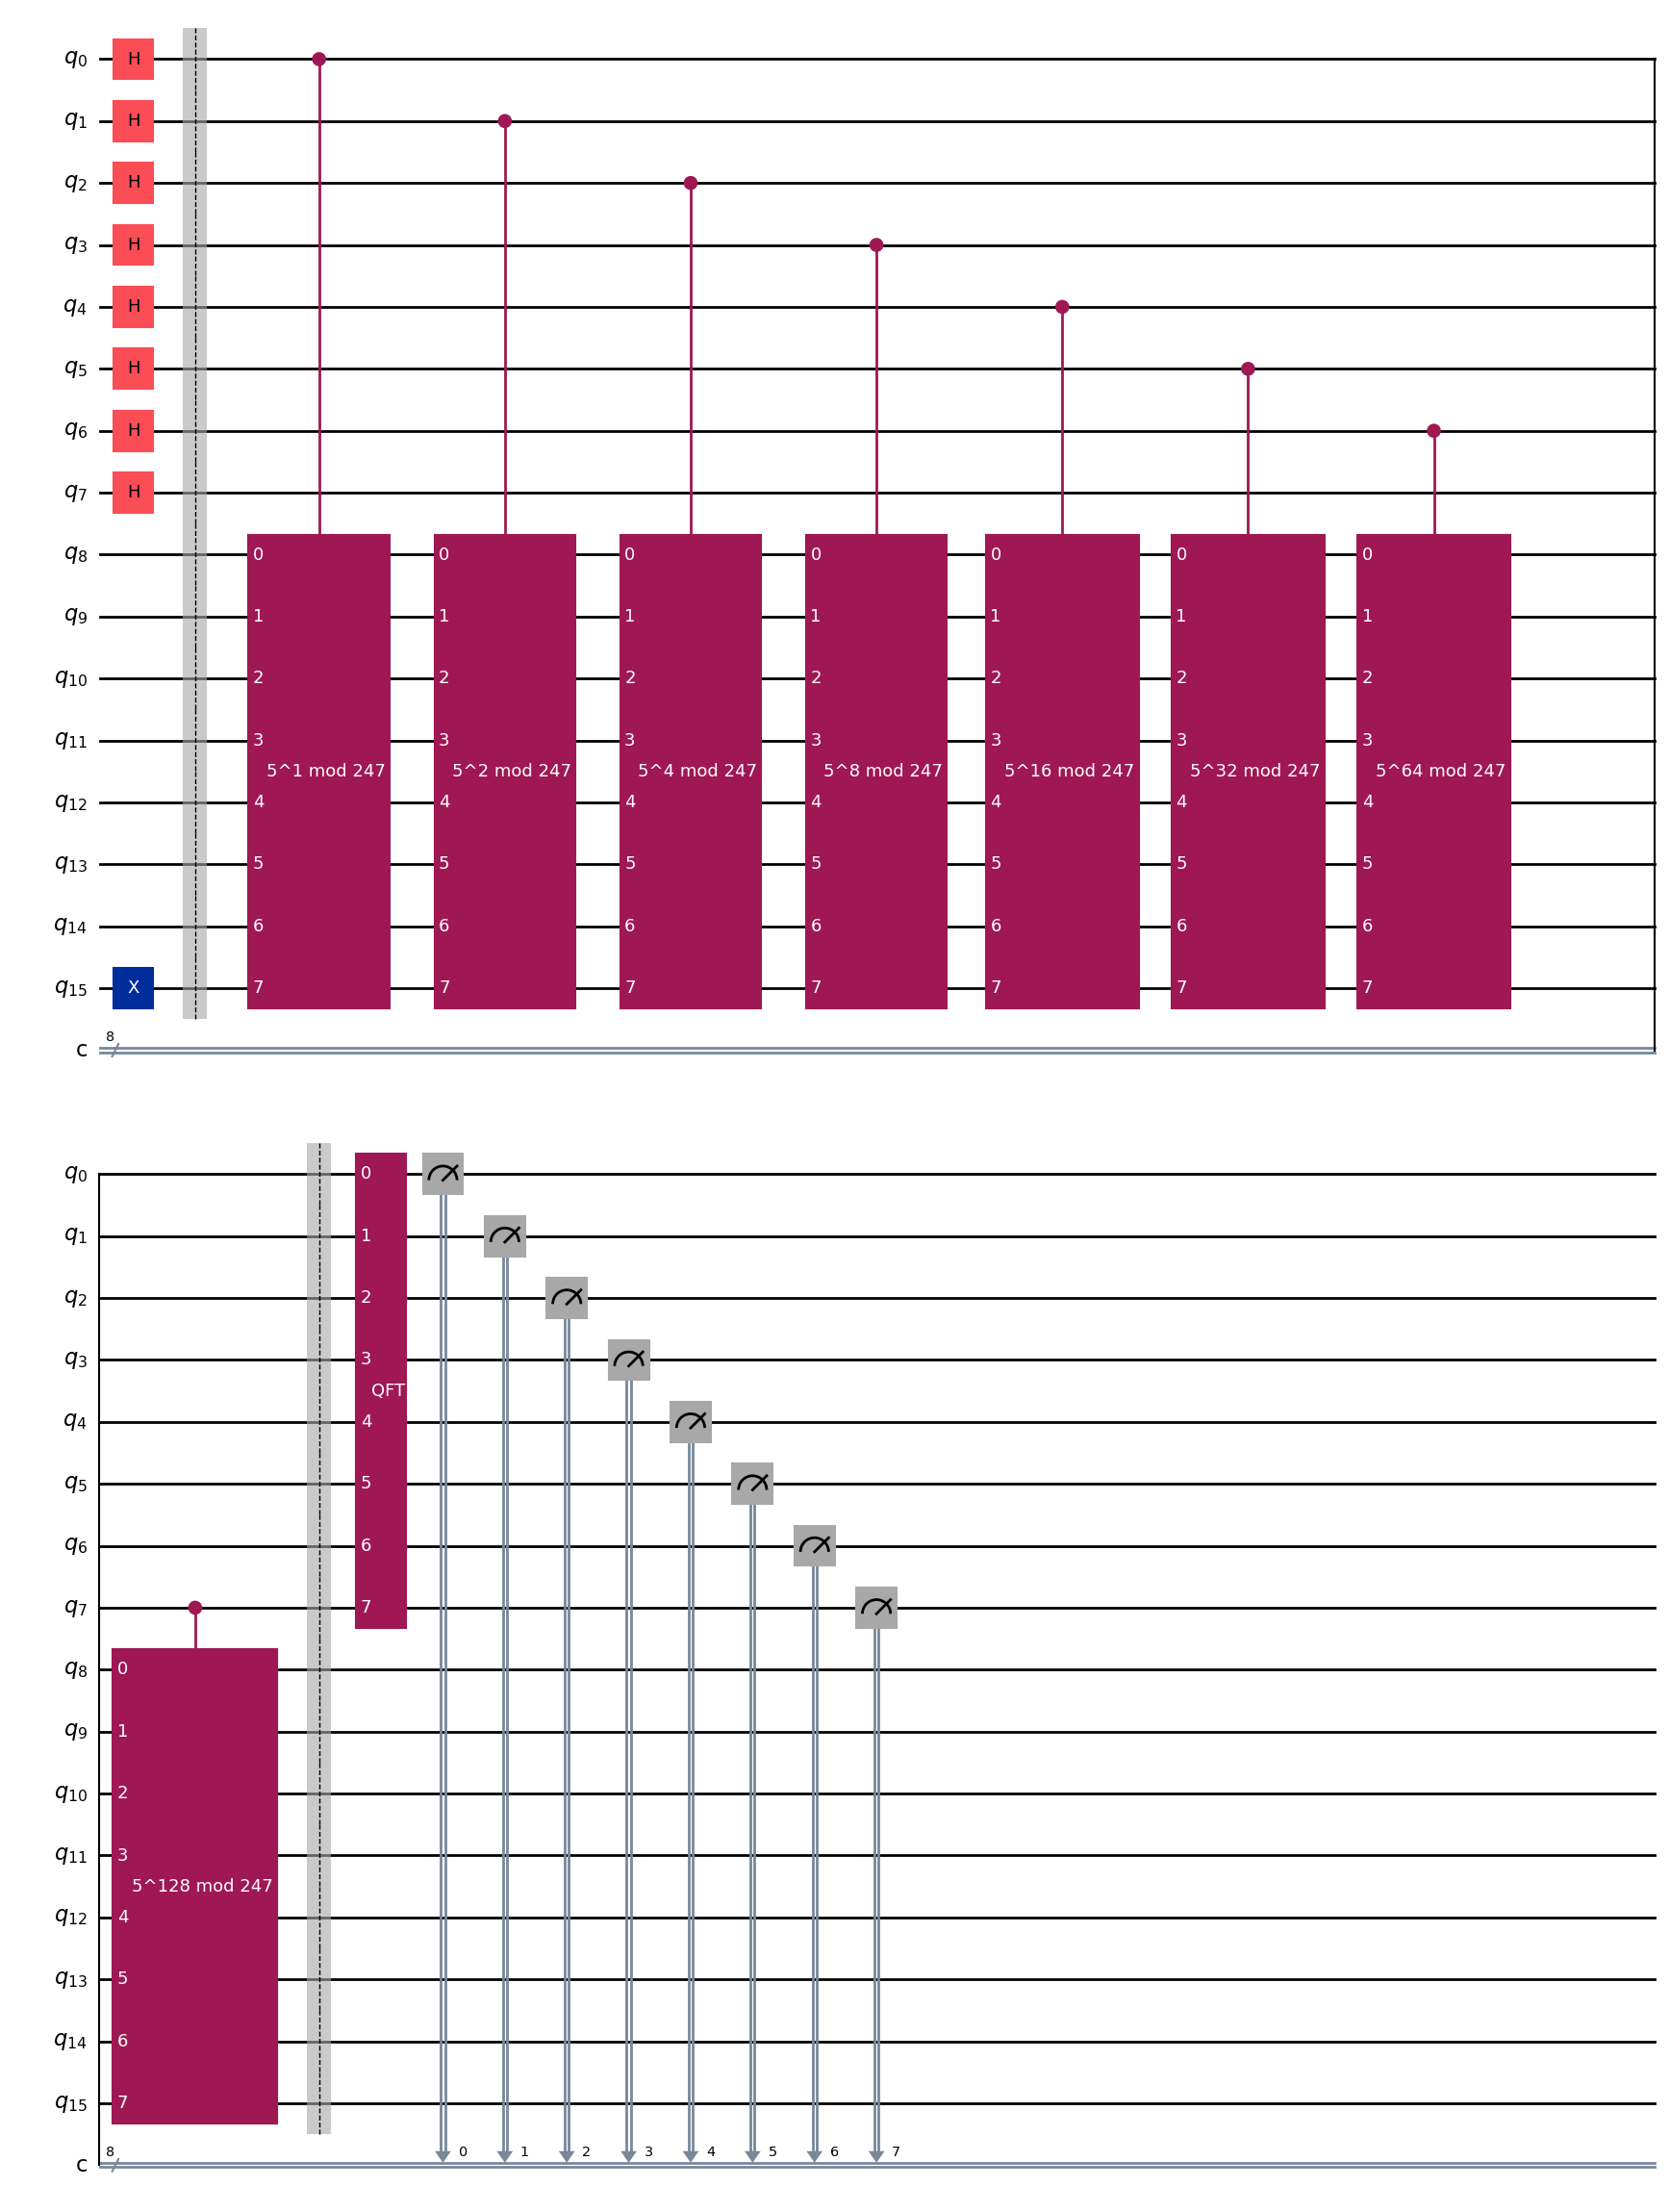

In [5]:
N_binary = toBinary(N) # Generate the binary representation of the number so that we can generate the number of qubits needed.
n = len(N_binary) 
m = 2 * n

circuit = QuantumCircuit(m, n)

# apply the hadamard gate to the input value
for i in range(n):
    circuit.h(i)

# Helper x gate
circuit.x(m-1)
circuit.barrier()

# Modify the circuit so that we can install the Controll-ROT gate.
# c_amodN implements an instance of the UROT gate per each power basis, 
# and the following loop tells the c_amodN gate which qubits it can 
# apply to.

for i in range(n):
    circuit.append(c_amodN(a, 2**i, N), [i]+[j+n for j in range(m-n)])

circuit.barrier()

qft = QFT(n)
qft.inverse()
circuit.append(qft, range(n))

circuit.measure(range(n), range(n))
display(circuit.draw('mpl'))

Design a sampler for running and simulating the Quantum Circuit. 

In [6]:
# Simulation using the sampler class.
def samplerSimulator(circuit):
    sampler = Sampler()
    results = sampler.run(circuit).result() # create a simulator to test the circuit and get the results from it.
    probabilities = results.quasi_dists # separate the probability of the values 
    return probabilities

# Secondary simulator using the BasicSimulator() class
def basicSimulator(circuit):
    backend = BasicSimulator()
    tqc = transpile(circuit, backend)
    counts = backend.run(tqc).result().get_counts()
    return counts

Get the results from the simulator

In [7]:
probabilities = samplerSimulator(circuit)
print(probabilities)

[{64: 0.1396484375, 128: 0.134765625, 0: 0.11328125, 32: 0.12109375, 192: 0.1064453125, 224: 0.1259765625, 160: 0.1318359375, 96: 0.126953125}]


Plot the graph with the given results/probabilities.

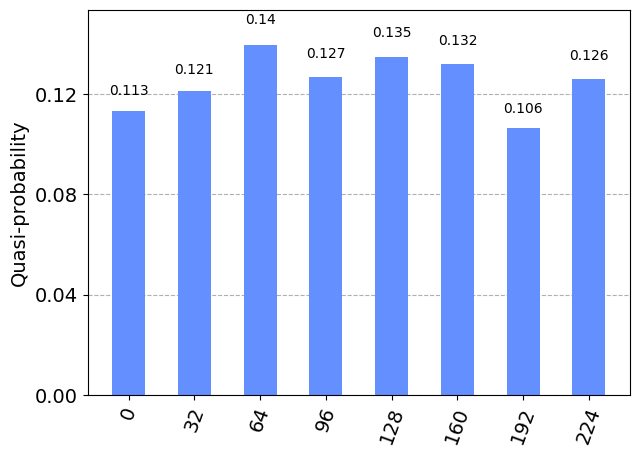

In [8]:
display(plot_histogram(probabilities))

Get the results from the simulator given the counts variable.

In [9]:
def getResultsList(probabilities):
    results_list = []
    for key in probabilities:     # unpack the map
        for j in key:      # get all the measured vectors
            if j == 0:     # if the output is 0, we can discard it since it is not usefult as a period guesser
                continue
            else:
                results_list.append(j)
    return results_list

Given two integers "p" and "q" from the results of testing the period "r", print the prime factors if they exist.

In [10]:
def printPQ(p, q):

    # The circuit implementation of Shor's algorithm cannot find a value for "p" and "q" if the value of "a"
    # from the start is a factor of the vale "N", thus we can inform the tester about it here
    if N % a == 0: 
        p = a
        q = N // a
        print("The value you chose for \"a\" is a factor of \"N\"!")
        print("N =",N)
        print("Prime Factor 1 =",p)
        print("Prime Factor 2 =",q)

    else:
        if p != 0:             # given a value p that is not 0/1, we can find the other value of q, since N = p * q => q = N / p
            q = N // p
        elif q != 0:           # given a value q that is not 0/1, we can find the other value of p, since N = p * q => p = N / q
            p = N // q

        if p == 0 and q == 0:  # if both p and q are 0, that means that we don't have propper factors, thus search for another value for "a"
            print("Try a different value for \"a\"!")
        else:
            print("N =",N)
            print("Prime Factor 1 =",p)
            print("Prime Factor 2 =",q)

Generate find the possible values for the period given by the simulator for "r" and test them to find the possible values for
"p" and "q".

In [11]:
# i. Extract the list of possible periods "r" from the results of the Quantum Simulation
r_options = getResultsList(probabilities)

print("Periodicity from the circuit =>",r_options)

# Find the values for the factors "p" and "q"
p = 0
q = 0
for i in r_options:
    if i % 2 == 0:
        x = (a**(i//2)) % N # Compute the periodicity check by applying modulus arithmetic.
        temp_p = math.gcd(x-1, N) # Find the GCD between the value of x-1 and N
        temp_q = math.gcd(x+1, N) # Find the GCD between the value of x+1 and N

        # if the values of temp_p and temp_q are 1 or N, then we need to check for other
        # values since they are not our key answers
        if temp_p != 1 and temp_p != N: 
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

Periodicity from the circuit => [64, 128, 32, 192, 224, 160, 96]


Given the values of "p" and "q" from above, check if one of them is a factor or not.
If none of them are factors of "N", print a message to test another value of "a".
If at least one of them is a factor, compute the other factor and print them.

In [12]:
printPQ(p, q)

N = 247
Prime Factor 1 = 13
Prime Factor 2 = 19


Testing the results of the circuit on another simulator to ensure the results are correct.

In [13]:
counts = basicSimulator(circuit)
print(counts)

keys = []
for i in counts:
    keys.append(i)

{'01000000': 140, '00100000': 134, '11000000': 128, '10000000': 117, '00000000': 122, '01100000': 126, '10100000': 121, '11100000': 136}


Printing the number of counts of the Basic Simulator.

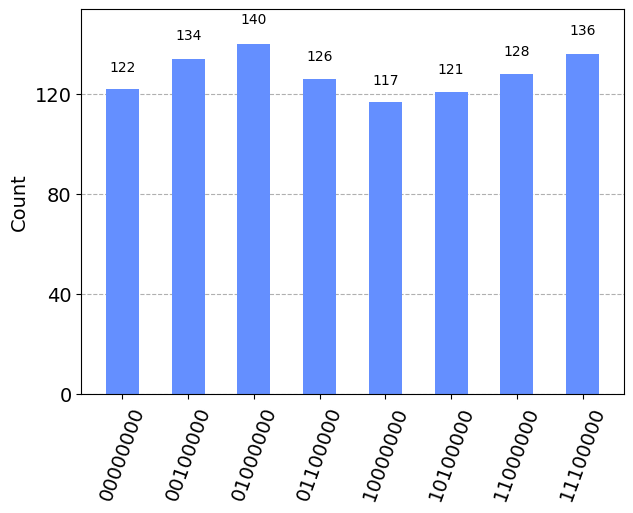

In [14]:
display(plot_histogram(counts))

Checking the candidates for the period "r" from the simulation. This computation is the same as for the previous simulation.

In [15]:
r_candidates = []
for i in keys:
    if toInteger(i) == 0:
        continue
    else:
        r_candidates.append(toInteger(i))

p = 0
q = 0
for i in r_candidates:
    if i % 2 == 0:
        x = (a**(i//2)) % N
        temp_p = math.gcd(x-1, N)
        temp_q = math.gcd(x+1, N)
        
        if temp_p != 1 and temp_p != N:
            p = temp_p
        if temp_q != 1 and temp_q != N:
            q = temp_q 
        else:
            continue
    else:
        continue

printPQ(p, q)

N = 247
Prime Factor 1 = 13
Prime Factor 2 = 19
